# Forcasting of wind speed

- The dataset contains speed, direction, tempreture and other features (6 features). The dataset is downloaded from the following study/repo https://github.com/HansBambel/multidim_conv.git. The following models are running in my own CPU, so it's very slow. It should be very fast if it runs on kaggle or google colab GPUs.

- The data was acquired from 7 cities in Netherlands

## Load Data

In [1]:
from src.load_data import read_raw_data, make_ready_data

In [2]:
train_data, test_data, scaler = read_raw_data()
train_data.shape, test_data.shape

((70128, 7, 6), (10872, 7, 6))

In [3]:
# min and max values of the data
scaler

{'Features': ['Wind speed in 0.1m/s',
  'Wind direction in degrees (360 North, 90 East, 0 No wind)',
  'Temperature in 0.1C',
  'Dew Point in 0.1C',
  'Air Pressure in 0.1hpa',
  'Rain amount in 0.1mm'],
 'feature_min_train': array([ 0.000e+00,  0.000e+00, -1.950e+02, -2.170e+02,  9.681e+03,
        -1.000e+00]),
 'feature_max_train': array([  240.,   360.,   376.,   230., 10462.,   481.])}

### Unified Models specs

Here we use the same specs for all the models

In [4]:
# input and output size are the number of series (cities)
input_size = output_size = 7

# hidden size is number of LSTM units, this means 32 as it's BiLSTM
hidden_size = 16

# Only one layer of LSTM
num_layers = 1

## Using LSTM Baseline
### 1 Hour ahead

In [5]:
# build time series features and labels
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=1)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=1)
xtrain.shape, xval.shape, ytrain.shape, yval.shape,xtest.shape, ytest.shape

((60000, 10, 7),
 (10116, 10, 7),
 (60000, 7),
 (10116, 7),
 (10860, 10, 7),
 (10860, 7))

In [6]:
from src.data_utils import build_dataloader
train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, ytrain, yval, ytest)

In [8]:
from src.models import LSTM
from src.run import run_train, validate

# build the model
lstm_baseline = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_baseline = lstm_baseline.to(device)

# train the model
lstm_baseline = run_train(lstm_baseline, train_iter, val_iter, num_epochs=10, features_set=1)

  0%|          | 2/938 [00:00<01:10, 13.37it/s]

Epoch:  1 , Train Loss:  0.0030722780667467794 , Val Loss:  0.002499804


  0%|          | 2/938 [00:00<01:05, 14.37it/s]

Epoch:  3 , Train Loss:  0.002417341914528838 , Val Loss:  0.0023514708


  0%|          | 2/938 [00:00<01:03, 14.82it/s]

Epoch:  5 , Train Loss:  0.002380242775768232 , Val Loss:  0.0023438607


  0%|          | 2/938 [00:00<01:16, 12.24it/s]

Epoch:  7 , Train Loss:  0.002363252814170092 , Val Loss:  0.0023354143


  0%|          | 2/938 [00:00<01:04, 14.55it/s]

Epoch:  9 , Train Loss:  0.002351572880569075 , Val Loss:  0.0023339605


100%|██████████| 159/159 [00:03<00:00, 45.46it/s]


In [11]:
from src.run import run_test
y_true, y_preds = run_test(lstm_baseline, test_iter, scaler, features_set=1)

100%|██████████| 170/170 [00:04<00:00, 40.37it/s]


RMSE:  11.822658
MAE:  8.9814415


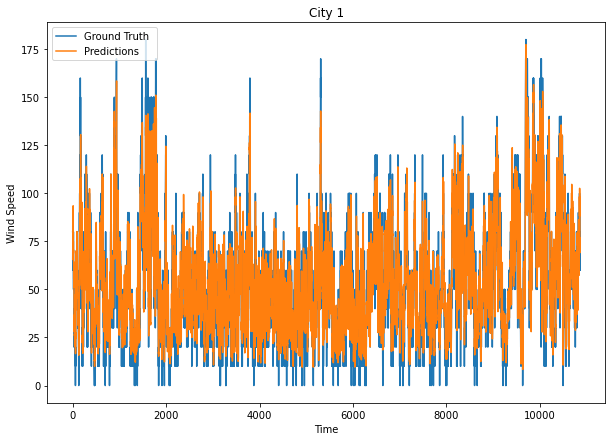

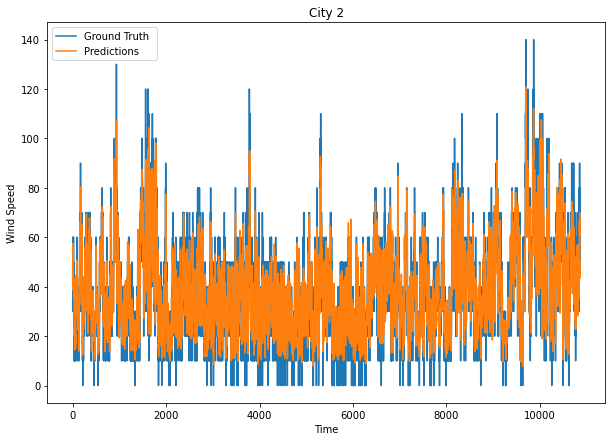

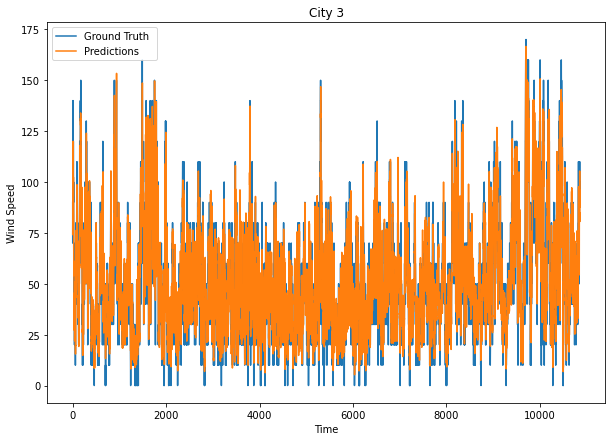

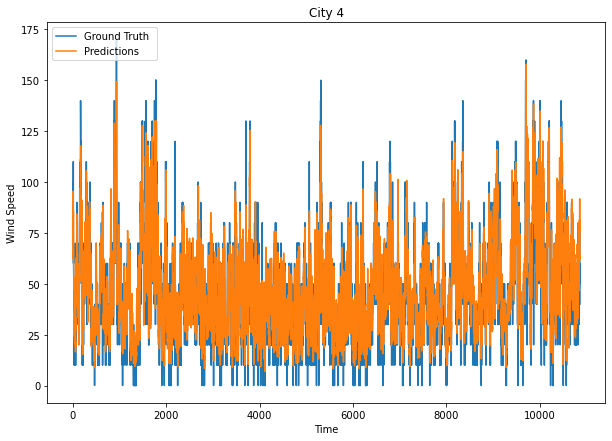

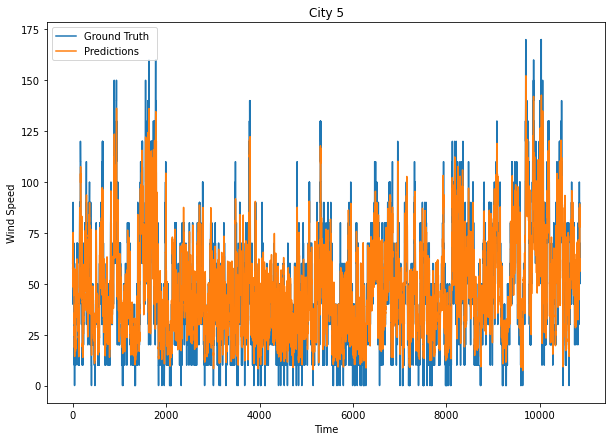

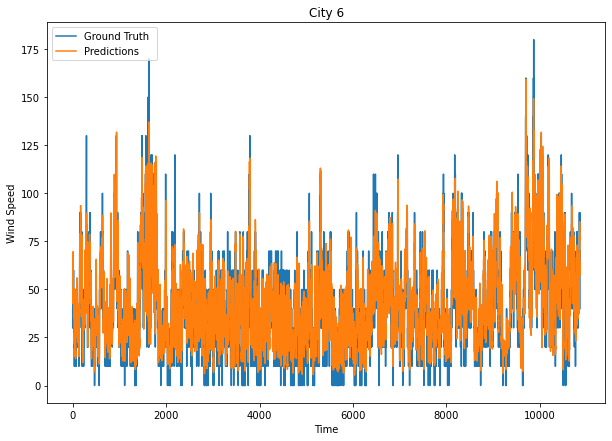

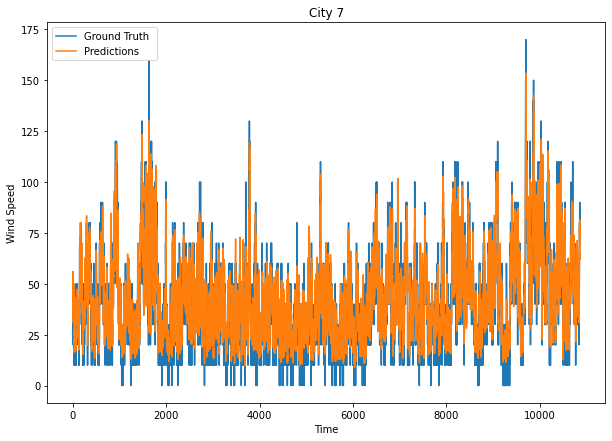

In [12]:
from src.vis import results
results(y_true, y_preds, plots=True)

### 5 Hours ahead

In [14]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=5)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=5)

train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, 
                                                           ytrain, yval, ytest)

lstm_baseline = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_baseline = lstm_baseline.to(device)
lstm_baseline = run_train(lstm_baseline, train_iter, val_iter, num_epochs=10, features_set=1)
y_true, y_preds = run_test(lstm_baseline, test_iter, scaler, features_set=1)

print('Test Data:')
results(y_true, y_preds, plots=False)

  0%|          | 2/938 [00:00<01:16, 12.28it/s]

Epoch:  1 , Train Loss:  0.006201700616401058 , Val Loss:  0.005478822


  0%|          | 2/938 [00:00<00:59, 15.80it/s]

Epoch:  3 , Train Loss:  0.005496261858203605 , Val Loss:  0.0053564757


  0%|          | 1/938 [00:00<01:49,  8.53it/s]

Epoch:  5 , Train Loss:  0.00537390019675133 , Val Loss:  0.0053055733


  0%|          | 2/938 [00:00<01:04, 14.48it/s]

Epoch:  7 , Train Loss:  0.005331488477233956 , Val Loss:  0.005182101


  0%|          | 2/938 [00:00<01:16, 12.19it/s]

Epoch:  9 , Train Loss:  0.005303231890557576 , Val Loss:  0.0051813307


100%|██████████| 170/170 [00:04<00:00, 39.08it/s]


Test Data:
RMSE:  17.769499
MAE:  13.737285


### 10 hours ahead

In [15]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=10)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=10)
train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, 
                                                           ytrain, yval, ytest)
lstm_baseline = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_baseline = lstm_baseline.to(device)
lstm_baseline = run_train(lstm_baseline, train_iter, val_iter, num_epochs=10, features_set=1)
y_true, y_preds = run_test(lstm_baseline, test_iter, scaler, features_set=1)

print('Test Data:')
results(y_true, y_preds, plots=False)

  0%|          | 2/938 [00:00<01:04, 14.43it/s]

Epoch:  1 , Train Loss:  0.008557759271289257 , Val Loss:  0.008087423


  0%|          | 1/938 [00:00<01:44,  8.94it/s]

Epoch:  3 , Train Loss:  0.007818190247264267 , Val Loss:  0.007909525


  0%|          | 2/938 [00:00<01:16, 12.18it/s]

Epoch:  5 , Train Loss:  0.007761208721667901 , Val Loss:  0.007835251


  0%|          | 2/938 [00:00<01:07, 13.78it/s]

Epoch:  7 , Train Loss:  0.007732605525249762 , Val Loss:  0.0078034867


  0%|          | 2/938 [00:00<01:04, 14.52it/s]

Epoch:  9 , Train Loss:  0.0077132972345542485 , Val Loss:  0.00778226


100%|██████████| 170/170 [00:04<00:00, 40.92it/s]


Test Data:
RMSE:  22.183584
MAE:  17.747887


### 50 Hours ahead

In [16]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=50)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=50)
train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, 
                                                           ytrain, yval, ytest)
lstm_baseline = LSTM(output_size, input_size, hidden_size, num_layers)
lstm_baseline = lstm_baseline.to(device)
lstm_baseline = run_train(lstm_baseline, train_iter, val_iter, num_epochs=10, features_set=1)
y_true, y_preds = run_test(lstm_baseline, test_iter, scaler, features_set=1)

print('Test Data:')
results(y_true, y_preds, plots=False)

  0%|          | 2/938 [00:00<01:02, 15.06it/s]

Epoch:  1 , Train Loss:  0.009822610314058731 , Val Loss:  0.00911387


  0%|          | 2/938 [00:00<01:12, 12.93it/s]

Epoch:  3 , Train Loss:  0.00932287292526181 , Val Loss:  0.008932725


  0%|          | 2/938 [00:00<01:02, 14.90it/s]

Epoch:  5 , Train Loss:  0.009274847771245629 , Val Loss:  0.0088932095


  0%|          | 2/938 [00:00<01:13, 12.73it/s]

Epoch:  7 , Train Loss:  0.009251795466001363 , Val Loss:  0.008868429


  0%|          | 2/938 [00:00<01:03, 14.66it/s]

Epoch:  9 , Train Loss:  0.009236466211042425 , Val Loss:  0.008852212


100%|██████████| 169/169 [00:03<00:00, 43.18it/s]


Test Data:
RMSE:  24.195305
MAE:  18.911278


## Using LSTM with BiLinear Pooling Fusion
### 1 Hour ahead

In [4]:
# build time series features and labels including tempreture time series
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=1)
xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, feature='tempreture', gap=1)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=1)
xtest_temp, _ = make_ready_data(test_data, train=False, feature='tempreture', gap=1)
xtrain.shape, xval.shape, ytrain.shape, yval.shape,xtest.shape, ytest.shape

((60000, 10, 7),
 (10116, 10, 7),
 (60000, 7),
 (10116, 7),
 (10860, 10, 7),
 (10860, 7))

In [5]:
# build dataloader
train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, 
                                                           xtrain_temp, xval_temp, 
                                                           xtest_temp, ytrain, 
                                                           yval, ytest)

In [9]:
from src.models import BiLinearPoolingLSTM

"""Here we use the same model specs as before such as 
input size, output size..etc"""

# build the model
lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)

# train the model
lstm_model = run_train(lstm_model, train_iter, val_iter, num_epochs=10)

  0%|          | 1/938 [00:00<02:37,  5.94it/s]

Epoch:  1 , Train Loss:  0.003111670906372519 , Val Loss:  0.0021834732


  0%|          | 1/938 [00:00<02:11,  7.13it/s]

Epoch:  3 , Train Loss:  0.0016815283793463571 , Val Loss:  0.0017920024


  0%|          | 1/938 [00:00<02:33,  6.10it/s]

Epoch:  5 , Train Loss:  0.0015423613013267746 , Val Loss:  0.0018554453


  0%|          | 1/938 [00:00<02:04,  7.52it/s]

Epoch:  7 , Train Loss:  0.0014694934159625015 , Val Loss:  0.0018146612


  0%|          | 1/938 [00:00<02:18,  6.74it/s]

Epoch:  9 , Train Loss:  0.0014332712985136347 , Val Loss:  0.0017976506


100%|██████████| 159/159 [00:08<00:00, 19.70it/s]


In [10]:
y_true, y_preds = run_test(lstm_model, test_iter, scaler)

100%|██████████| 170/170 [00:09<00:00, 18.87it/s]


RMSE:  10.86005
MAE:  7.160864


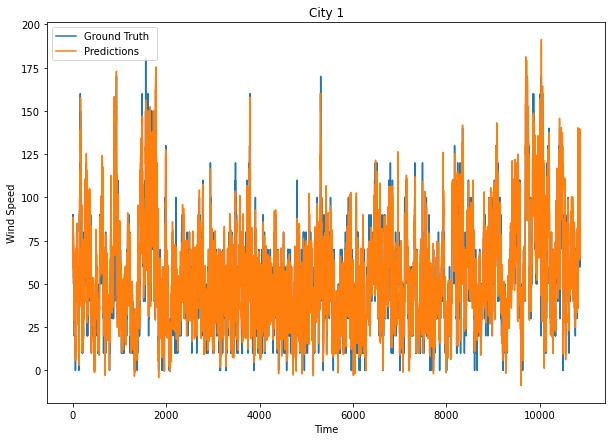

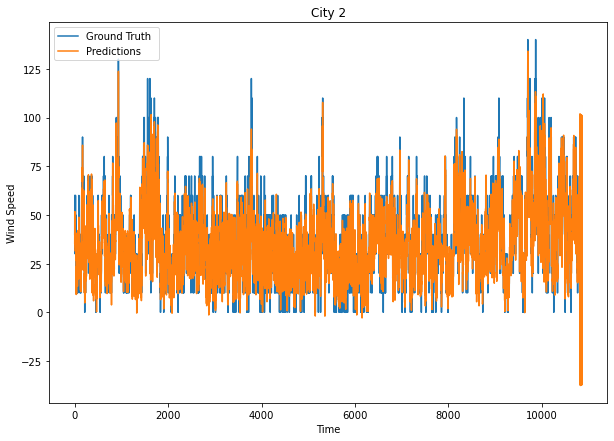

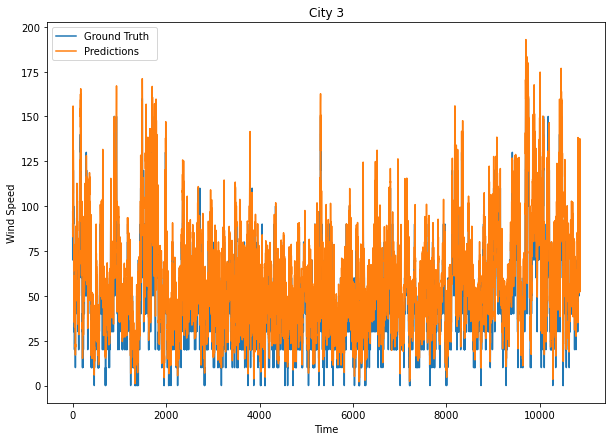

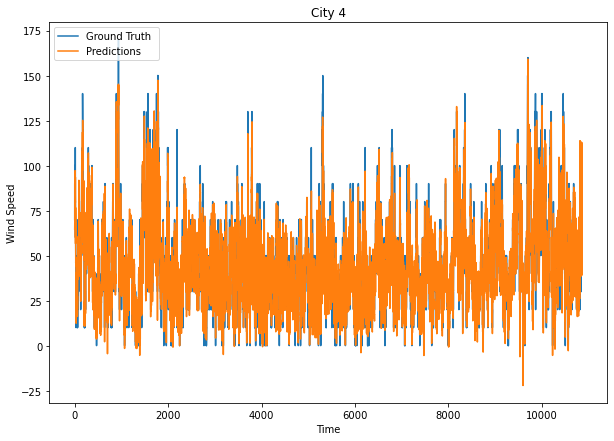

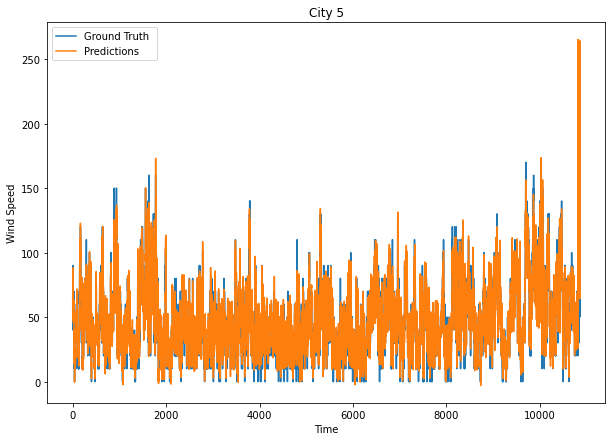

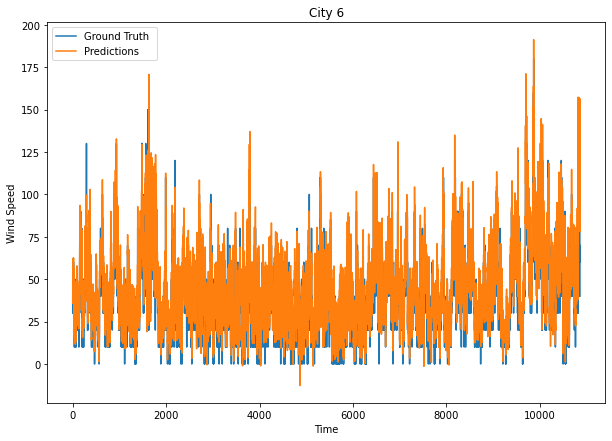

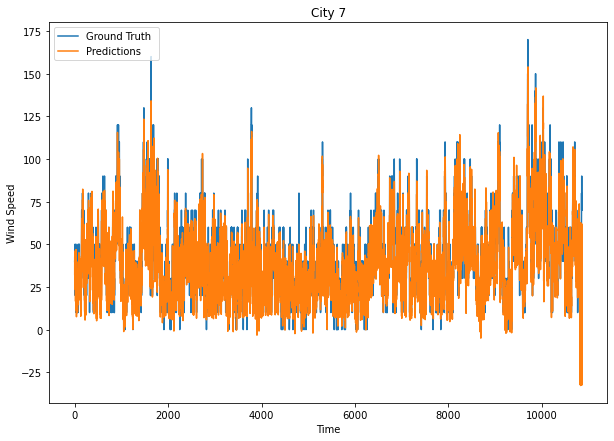

In [11]:
results(y_true, y_preds, plots=True)

The very last few predictions gives exaggerated higher or lower values.. The reason for this is not understood yet. By taking the first 100 time steps in the test

RMSE:  8.790627
MAE:  6.267405


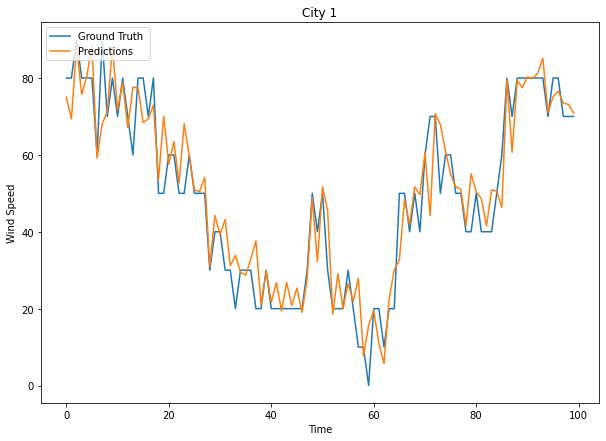

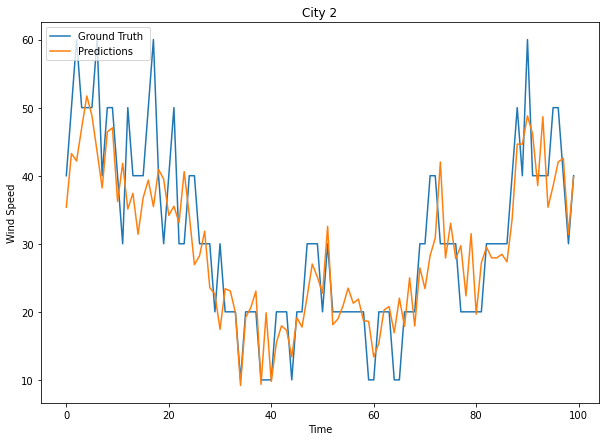

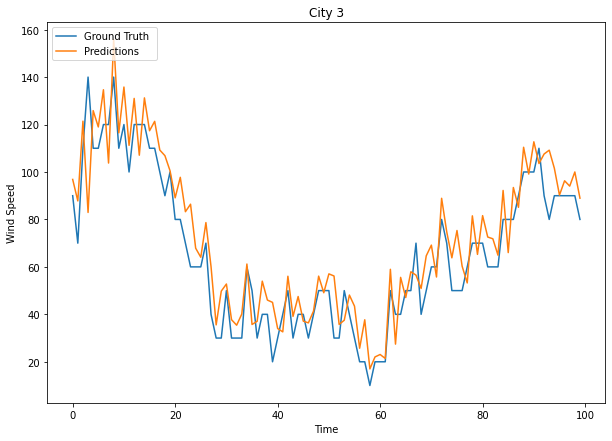

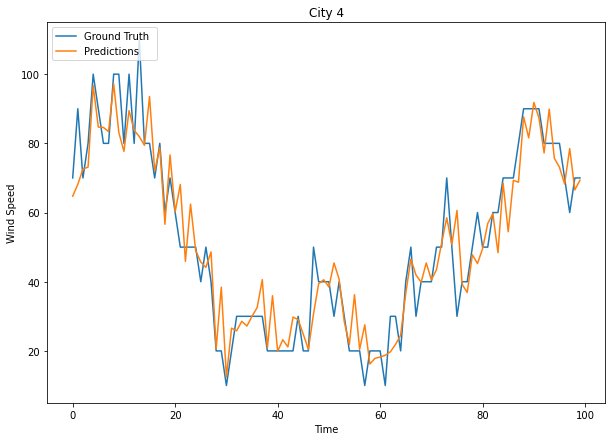

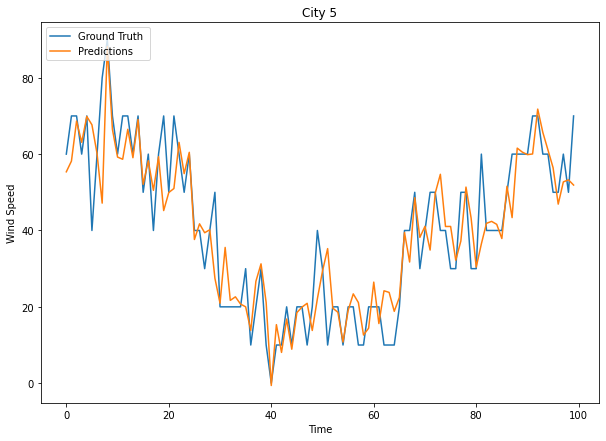

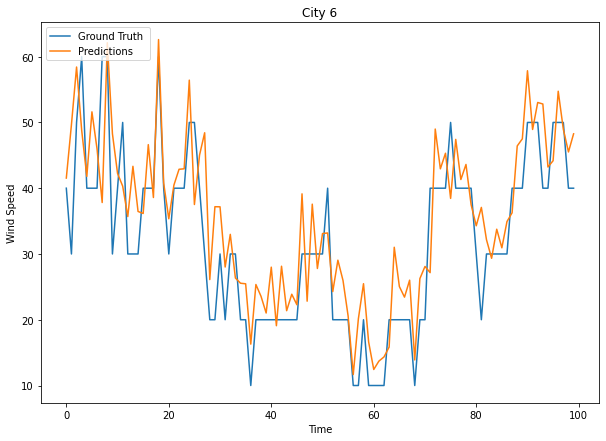

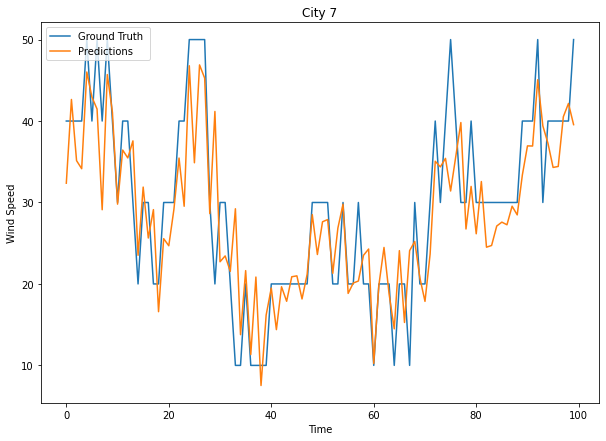

In [12]:
results(y_true[:100], y_preds[:100], plots=True)

### 5 Hours ahead

In [14]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=5)
xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, feature='tempreture', gap=5)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=5)
xtest_temp, _ = make_ready_data(test_data, train=False, feature='tempreture', gap=5)

train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, 
                                                           xtrain_temp, xval_temp, 
                                                           xtest_temp, ytrain, 
                                                           yval, ytest)

lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)
lstm_model = run_train(lstm_model, train_iter, val_iter, num_epochs=10)
y_true, y_preds = run_test(lstm_model, test_iter, scaler)

print('Test Data:')
results(y_true, y_preds, plots=False)

100%|██████████| 170/170 [00:07<00:00, 21.56it/s]


Test Data:
RMSE:  13.428458
MAE:  9.382977


### 10 Hours ahead

In [15]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=10)
xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, feature='tempreture', gap=10)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=10)
xtest_temp, _ = make_ready_data(test_data, train=False, feature='tempreture', gap=10)

train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, 
                                                           xtrain_temp, xval_temp, 
                                                           xtest_temp, ytrain, 
                                                           yval, ytest)

lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)

lstm_model = run_train(lstm_model, train_iter, val_iter, num_epochs=10)
y_true, y_preds = run_test(lstm_model, test_iter, scaler)

print('Test Data:')
results(y_true, y_preds, plots=False)

  0%|          | 1/938 [00:00<02:05,  7.47it/s]

Epoch:  1 , Train Loss:  0.005885085046563401 , Val Loss:  0.004593782


  0%|          | 1/938 [00:00<02:27,  6.34it/s]

Epoch:  3 , Train Loss:  0.004787160969673912 , Val Loss:  0.0044041327


  0%|          | 1/938 [00:00<02:18,  6.77it/s]

Epoch:  5 , Train Loss:  0.004609024777550743 , Val Loss:  0.0043800664


  0%|          | 1/938 [00:00<01:36,  9.66it/s]

Epoch:  7 , Train Loss:  0.004483390767782577 , Val Loss:  0.004343743


  0%|          | 1/938 [00:00<01:45,  8.85it/s]

Epoch:  9 , Train Loss:  0.0043527682842776135 , Val Loss:  0.004311968


100%|██████████| 170/170 [00:07<00:00, 22.70it/s]


Test Data:
RMSE:  16.177444
MAE:  11.55844


### 50 Hours ahead

In [17]:
xtrain, xval, ytrain, yval = make_ready_data(train_data, feature='speed',gap=50)
xtrain_temp, xval_temp, _, _ = make_ready_data(train_data, feature='tempreture', gap=50)
xtest, ytest = make_ready_data(test_data, train=False, feature='speed', gap=50)
xtest_temp, _ = make_ready_data(test_data, train=False, feature='tempreture', gap=50)

train_iter, val_iter, test_iter, device = build_dataloader(xtrain, xval, xtest, 
                                                           xtrain_temp, xval_temp, 
                                                           xtest_temp, ytrain, 
                                                           yval, ytest)

lstm_model = BiLinearPoolingLSTM(output_size, input_size, hidden_size, num_layers)
lstm_model = lstm_model.to(device)

lstm_model = run_train(lstm_model, train_iter, val_iter, num_epochs=10)
y_true, y_preds = run_test(lstm_model, test_iter, scaler)

print('Test Data:')
results(y_true, y_preds, plots=False)

  0%|          | 1/938 [00:00<01:55,  8.09it/s]

Epoch:  1 , Train Loss:  0.00916472104462936 , Val Loss:  0.008026335


  0%|          | 1/938 [00:00<01:54,  8.19it/s]

Epoch:  3 , Train Loss:  0.008410217360963724 , Val Loss:  0.008061015


  0%|          | 1/938 [00:00<02:51,  5.47it/s]

Epoch:  5 , Train Loss:  0.00830098091605316 , Val Loss:  0.0081050275


  0%|          | 1/938 [00:00<02:04,  7.51it/s]

Epoch:  7 , Train Loss:  0.008202261155543686 , Val Loss:  0.008240694


  0%|          | 1/938 [00:00<02:17,  6.84it/s]

Epoch:  9 , Train Loss:  0.00813093787664349 , Val Loss:  0.008532233


100%|██████████| 169/169 [00:07<00:00, 22.77it/s]

Test Data:
RMSE:  22.812965
MAE:  17.330458
